# Rocket + MiniRocket

***Berlin Time Series Analysis Meetup***

Angus Dempster

Monash University, Melbourne

***

# Contents

1. [Time Series Classification](#1—Time-Series-Classification)
2. [Rocket](#2—Rocket)
3. [MiniRocket](#3—MiniRocket)
  1. [Kernels](#A—Kernels)
  2. [Dilation](#B—Dilation)
  3. [Bias + PPV](#C—Bias-+-PPV)
  4. [Classifier(s)](#D—Classifier(s))
  5. [Optimisations](#E—Optimisations)

***

# Imports etc

In [1]:
import matplotlib.pyplot as pl

import numpy as np

import torch, torch.nn as nn, torch.nn.functional as F

In [2]:
# sinusoidal signal, 2 frequencies + noise
def example(n, a = 2, b = 14):
    X  = torch.sin(torch.linspace(0, np.pi * a, n)).view(1, 1, -1)
    X += torch.sin(torch.linspace(0, np.pi * b, n)) * 0.25
    X += torch.randn(n) * 0.05
    
    return X

***

# 1—Time Series Classification

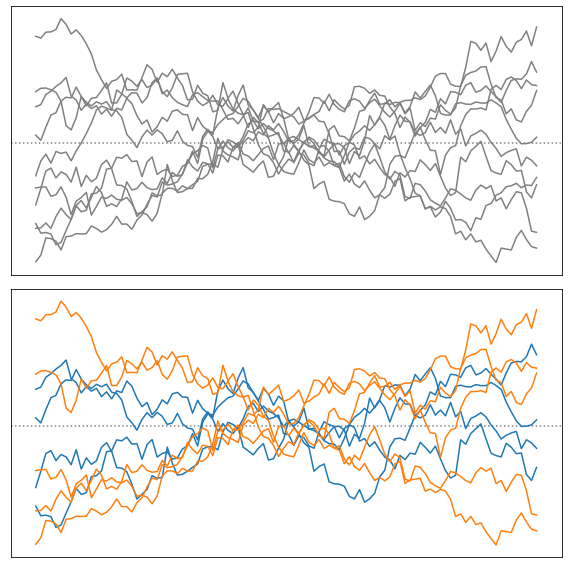

In [3]:
X = torch.randn(10, 100).cumsum(-1)
X -= X.mean(-1, keepdim = True)

Y = X.abs().sum(-1)
m = Y.median()

f, a = pl.subplots(2, 1, figsize = (8, 8), sharex = True, sharey = True)

a[0].axhline(0, ls = ":", c = "grey")
a[0].plot(X.T, c = "grey")

a[1].axhline(0, ls = ":", c = "grey")
a[1].plot(X[Y < m].T, c = "C0")
a[1].plot(X[Y > m].T, c = "C1")

for _a in a:
    _a.set(xticks = [], yticks = [])

f.tight_layout()

pl.show()

***

# 2—Rocket

Dempster, Petitjean, Webb (2020) Rocket: Exceptionally Fast and Accurate Time Classification Using Random
Convolutional Kernels, *Data Mining and Knowledge Discovery*, 34, 1454–1495, [arXiv:1910.13051](https://arxiv.org/abs/1910.13051), [10.1007/s10618-020-00701-z](https://doi.org/10.1007/s10618-020-00701-z), [github.com/angus924/rocket](https://github.com/angus924/rocket).

input $\longrightarrow$ random convolution $\longrightarrow$ pooling (ppv + max) $\longrightarrow$ classifier

random length, weights, bias, dilation, and padding

***

# 3—MiniRocket

Dempster, Schmidt, Webb (2020) MiniRocket: A Very Fast (Almost) Deterministic Transform for Time Series Classification, [arXiv:2012.08791](https://arxiv.org/abs/2012.08791), [github.com/angus924/minirocket](https://github.com/angus924/minirocket).

random $\longrightarrow$ (mostly) nonrandom

fast $\longrightarrow$ *much* faster (75x)

## A—Kernels

* small, fixed set of kernels
* empirical, not magical

### A.1—Example Kernel

In [4]:
indices = torch.combinations(torch.arange(9), 3).unsqueeze(1)

W = -torch.ones(indices.shape[0], 1, 9)
W = W.scatter(-1, indices, 2)

In [5]:
# indices

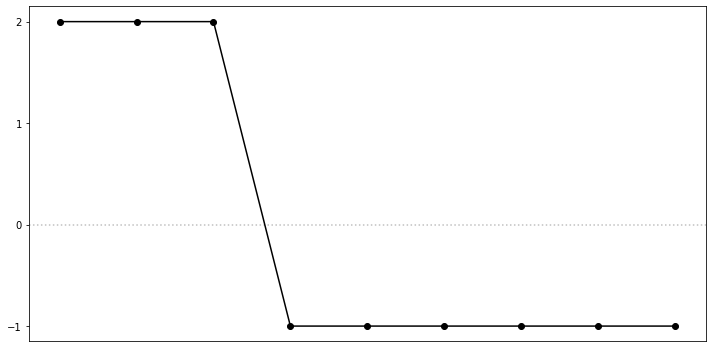

In [6]:
f, a = pl.subplots(1, 1, figsize = (10, 5))

a.axhline(0, ls = ":", c = "silver")
a.plot(W[0].squeeze(), "ko-")
a.set(
    xticks = [],
    yticks = np.arange(-1, 2 + 1)
)

f.tight_layout()

pl.show()

### A.2—Set of All Kernels

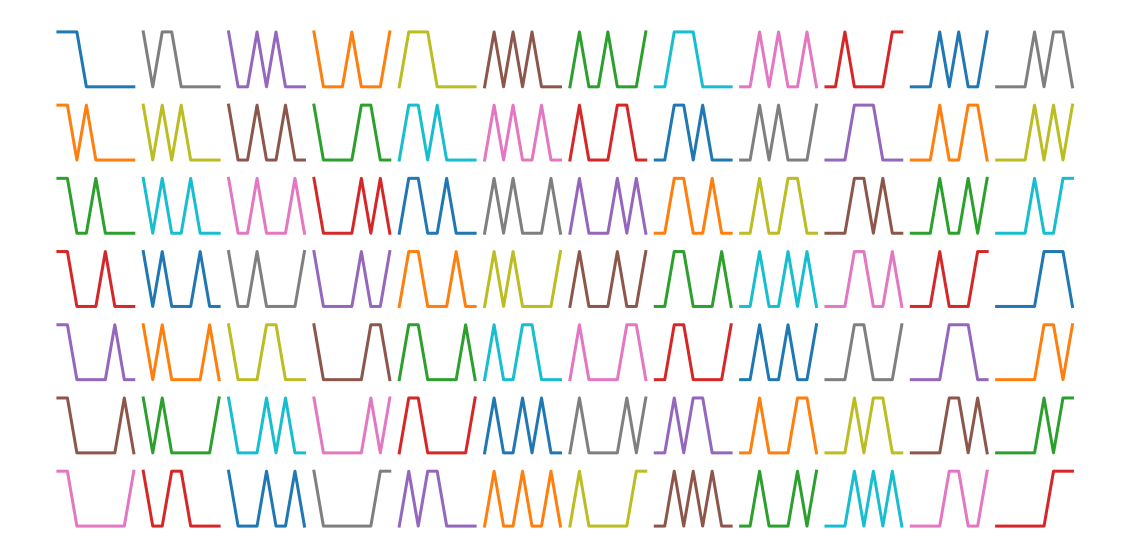

In [7]:
f, a = pl.subplots(1, 1, figsize = (20, 10))

h = 0
v = 0

for i in range(W.shape[0]):
    
    a.plot(np.arange(9) + h * 9, W[i].squeeze() - v * 4, lw = 3)
    
    v += 1
    
    if v >= 7:
        v = 0
        h += 1

a.axis("off")
    
pl.show()

## B—Dilation

### B.1—Effect of Dilation

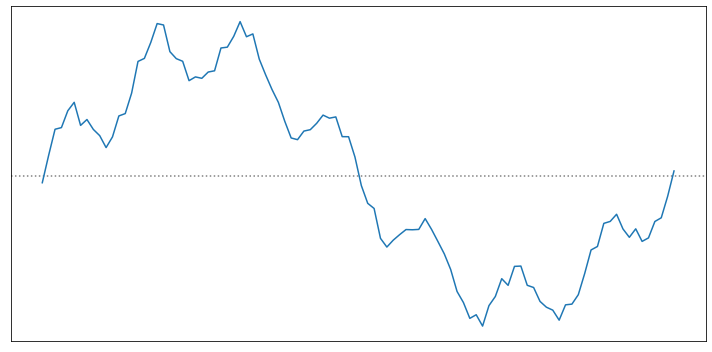

In [8]:
X = example(100)

f, a = pl.subplots(1, 1, figsize = (10, 5))

a.axhline(0, ls = ":", c = "grey")
a.plot(X.squeeze())
a.set(xticks = [], yticks = [])

f.tight_layout()

pl.show()

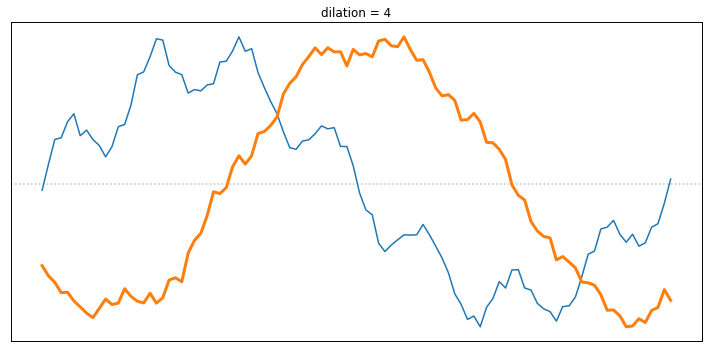

In [9]:
dilation = 4

Z = F.conv1d(X, W[0].unsqueeze(0), dilation = dilation, padding = 4 * dilation)

f, a = pl.subplots(1, 1, figsize = (10, 5))

b = a.twinx()

a.axhline(0, ls = ":", c = "silver")
a.plot(X.squeeze(), label = r"$X$")
b.plot(Z.squeeze(), "C1", lw = 3)
a.set(xticks = [], yticks = [], title = f"dilation = {dilation}")
b.set(yticks = [])

f.tight_layout()

pl.show()

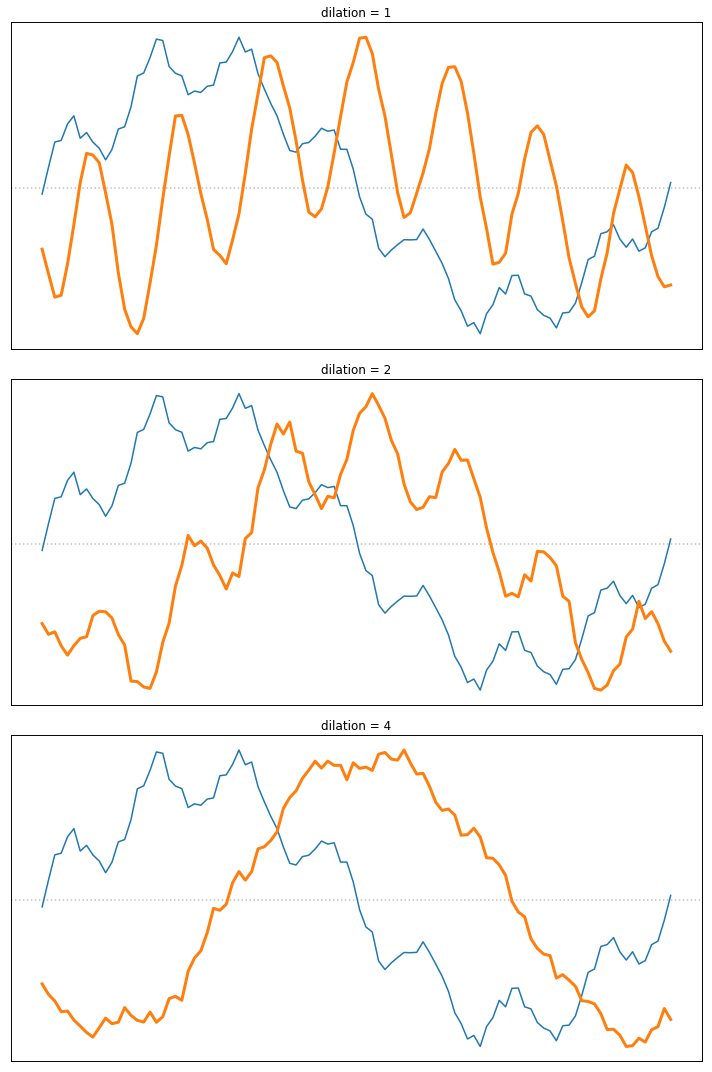

In [10]:
D = [1, 2, 4]

f, a = pl.subplots(len(D), 1, figsize = (10, 5 * len(D)), sharex = True, sharey = True)

for i, d in enumerate(D):
    
    Z = F.conv1d(X, W[0].unsqueeze(0), dilation = d, padding = 4 * d)
    
    b = a[i].twinx()
    
    a[i].axhline(0, ls = ":", c = "silver")
    
    a[i].plot(X.squeeze())
    b.plot(Z.squeeze(), "C1", lw = 3)
    a[i].set(xticks = [], yticks = [], title = f"dilation = {d}")
    b.set(yticks = [])

f.tight_layout()

pl.show()

### B.2—All Kernels + Dilations

In [11]:
class Transform(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        indices = torch.combinations(torch.arange(9), 3).unsqueeze(1)

        self.W = (-torch.ones(indices.shape[0], 1, 9)).scatter(-1, indices, 2)
    
    def forward(self, X):
        
        N, *_, L = X.shape
        
        D = torch.unique((2 ** torch.linspace(0, torch.log2(torch.tensor(L - 1).float() / 8), 32)).int())
                
        Z = torch.zeros(N, D.shape[0], self.W.shape[0], L)
        
        for i, d in enumerate(D):
            
            Z[:, i] = F.conv1d(X, self.W, dilation = d.item(), padding = 4 * d.item())
        
        return Z

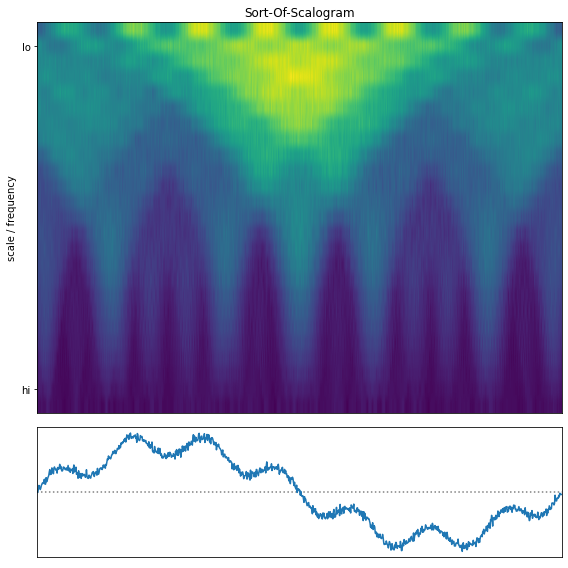

In [12]:
# X = example(100)
X = example(1_000)

model = Transform()

Z = model(X)

f, a = pl.subplots(2, 1, figsize = (8, 8), gridspec_kw = {"height_ratios" : (3, 1)}, sharex = True)

n = Z.shape[1]
u = int(n * 0.05)
v = int(n * 0.95)

a[0].imshow(Z[0].abs().mean(1).flip(0), aspect = "auto")
a[0].set(
    xticks = [],
    xlabel = "",
    yticks = [u, v],
    yticklabels = ["lo", "hi"],
    ylabel = "scale / frequency",
    title = "Sort-Of-Scalogram"
)

a[1].axhline(0, ls = ":", c = "grey")
a[1].plot(X.squeeze())
a[1].set(xticks = [], yticks = [])

f.tight_layout()

pl.show()

## C—Bias + PPV

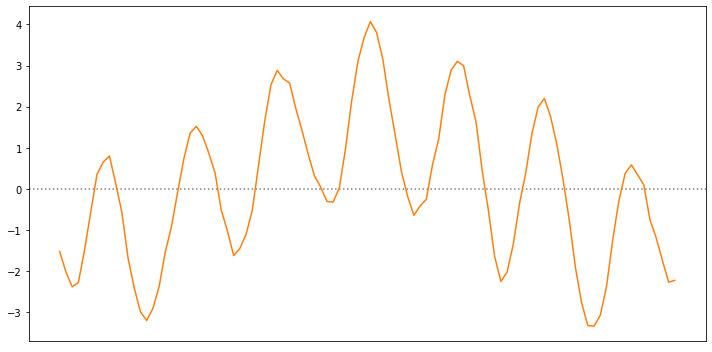

In [13]:
X = example(100)

Z = F.conv1d(X, W[0].unsqueeze(0), dilation = 1, padding = 4).squeeze()

f, a = pl.subplots(1, 1, figsize = (10, 5))

a.axhline(0, ls = ":", c = "grey")
a.plot(Z, "C1")
a.set(xticks = [])

f.tight_layout()

pl.show()

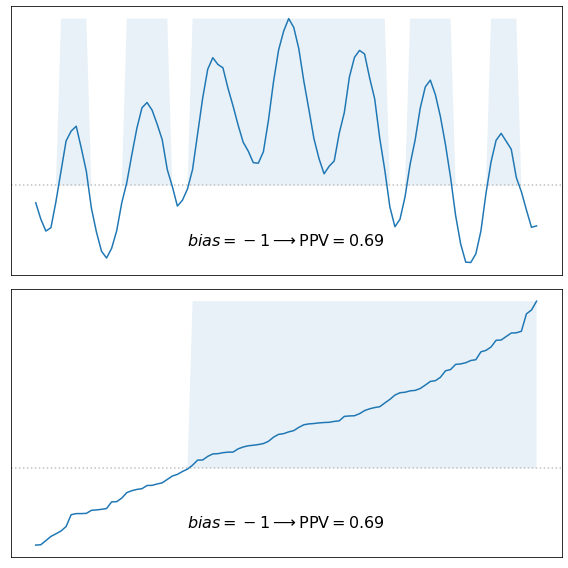

In [14]:
Z = F.conv1d(X, W[0].unsqueeze(0), dilation = 1, padding = 4).squeeze()

bias = -1

Z = Z - bias
Z_sorted = torch.sort(Z)[0]

_Z = (Z > 0).float()
_Z_sorted = (Z_sorted > 0).float()

ppv = round(float(_Z.mean()), 4)
ppv_sorted = round(float(_Z_sorted.mean()), 4)

# ==========

f, a = pl.subplots(2, 1, figsize = (8, 8), sharex = True, sharey = True)

a[0].axhline(0, ls = ":", c = "silver")
a[0].plot(Z)
a[0].fill_between(np.arange(len(_Z)), 0, _Z * Z.max(), alpha = 0.1)
a[0].annotate(rf"$bias = {bias} \longrightarrow \rm{{PPV}} = {ppv}$",
              (0.5, 0.1),
              xycoords = "axes fraction",
              ha = "center",
              va = "bottom",
              fontsize = 16)
a[0].set(xticks = [], yticks = [])

a[1].axhline(0, ls = ":", c = "silver")
a[1].plot(Z_sorted)
a[1].fill_between(np.arange(len(_Z_sorted)), 0, _Z_sorted * Z_sorted.max(), alpha = 0.1)
a[1].annotate(rf"$bias = {bias} \longrightarrow \rm{{PPV}} = {ppv_sorted}$",
              (0.5, 0.1),
              xycoords = "axes fraction",
              ha = "center",
              va = "bottom",
              fontsize = 16)
a[1].set(xticks = [], yticks = [])

f.tight_layout()

pl.show()

## D—Classifier(s)

* small/medium datasets: ridge regression classifier
* large datasets: logistic regression (PyTorch)

## E—Optimisations

### E.1—$PPV(X*W)$ vs $PPV(X*-W)$

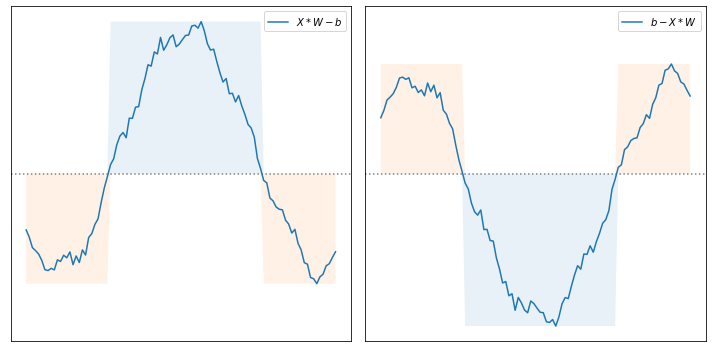

In [15]:
Z_0 = F.conv1d(X,  W[0].unsqueeze(0), dilation = 4, padding = 4 * 4).squeeze()
Z_1 = F.conv1d(X, -W[0].unsqueeze(0), dilation = 4, padding = 4 * 4).squeeze()

bias = 0

PV_0 = (Z_0 - bias > 0).float()
PV_1 = (Z_1 + bias > 0).float()

f, a = pl.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)

a[0].axhline(0, ls = ":", c = "grey")
a[1].axhline(0, ls = ":", c = "grey")

a[0].plot(Z_0 - bias, label = rf"$X*W-b$")
a[1].plot(Z_1 + bias, label = rf"$b-X*W$")

a[0].fill_between(np.arange(Z_0.shape[0]), 0, PV_0 * (Z_0 - bias).max(), alpha = 0.1)
a[0].fill_between(np.arange(Z_0.shape[0]), (1 - PV_0) * (Z_0 - bias).min(), 0, alpha = 0.1)

a[1].fill_between(np.arange(Z_0.shape[0]), (1 - PV_1) * (Z_1 + bias).min(), 0, alpha = 0.1)
a[1].fill_between(np.arange(Z_1.shape[0]), 0, PV_1 * (Z_1 + bias).max(), alpha = 0.1)

a[0].set(xticks = [], yticks = [])

a[0].legend()
a[1].legend()

f.tight_layout()

pl.show()

### E.2—Recycle $X*W$

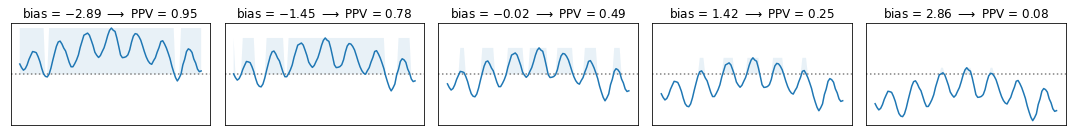

In [16]:
X = example(100)

Z = F.conv1d(X, W[0].unsqueeze(0), dilation = 1, padding = 4).squeeze()

B = np.linspace(Z.min() * 0.75, Z.max() * 0.75, 5)

n = B.shape[0]

f, a = pl.subplots(1, n, figsize = (3 * n, 2), sharex = True, sharey = True)

for i, b in enumerate(B):
    
    _Z = Z - b
    
    PPV = float((_Z > 0).float().mean())
    
    a[i].axhline(0, ls = ":", c = "grey")
    a[i].plot(Z - b)
    a[i].fill_between(np.arange(Z.shape[0]), 0, (_Z > 0).float() * _Z.max(), alpha = 0.1)
    a[i].set(xticks = [], yticks = [], title = f"bias = ${round(b, 2)}$ $\longrightarrow$ PPV = ${round(PPV, 2)}$")

f.tight_layout()

pl.show()

### E.3—Convolution by Addition (1)

*Avoid Multiplications*

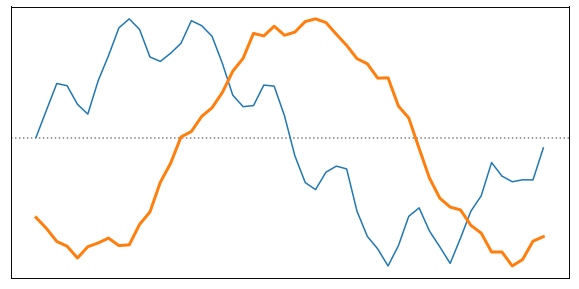

In [17]:
X = example(50)

dilation = 2

Z = F.conv1d(X, W[0].unsqueeze(0), dilation = dilation, padding = 4 * dilation).squeeze()

f, a = pl.subplots(1, 1, figsize = (10, 5))

b = a.twinx()

a.axhline(0, ls = ":", c = "grey")
a.plot(X.squeeze())
a.set(xticks = [], yticks = [])

b.plot(Z, "C1", lw = 3)
b.set(yticks = [])

pl.show()

In [18]:
unfold = nn.Unfold((1, 9), dilation = (1, dilation), padding = (0, 4 * dilation))

In [19]:
A = -unfold(X.unsqueeze(0))

A.shape

torch.Size([1, 9, 50])

In [20]:
B = 2 * unfold(X.unsqueeze(0))

B.shape

torch.Size([1, 9, 50])

In [21]:
C = A.clone()

C[:, indices[0], :] = B[:, indices[0], :]

C.shape

torch.Size([1, 9, 50])

In [22]:
C_sum = C.sum(1)

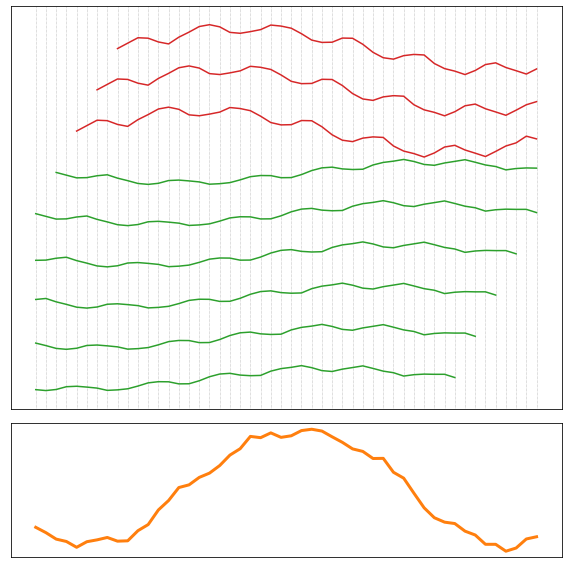

In [23]:
f, a = pl.subplots(2, 1, figsize = (8, 8), gridspec_kw = {"height_ratios" : (3, 1)}, sharex = True)

C_plot = C.clone()
C_plot[C_plot == 0] = np.nan

[a[0].axvline(i, ls = ":", lw = 0.5, c = "grey") for i in range(A.shape[-1])]

a[0].plot(C_plot.squeeze()[:3].T - torch.arange(3).float() * 4, "C3")
a[0].plot(C_plot.squeeze()[3:].T - torch.arange(3, 9).float() * 4, "C2")
a[0].set(xticks = [], yticks = [])

a[1].plot(C_sum.squeeze(), "C1", lw = 3)
a[1].set(yticks = [])

f.tight_layout()

pl.show()

### E.4—Convolution by Addition (2) [All Kernels at Once]

*Compute $X*W$ for All Kernels At Once (Almost)*

Compute $C_{A}$ $\longrightarrow$ *once per dilation*

*sum over 9 rows, once per dilation*

In [24]:
A = -unfold(X.unsqueeze(0))

A.shape

torch.Size([1, 9, 50])

In [25]:
A = A.sum(1)

A.shape

torch.Size([1, 50])

Compute $C_{G}^{W} = 3X$ $\longrightarrow$ *once per kernel*

*sum over 3 rows, once per kernel (per dilation)*

In [26]:
G = 3 * unfold(X.unsqueeze(0))

G.shape

torch.Size([1, 9, 50])

In [27]:
G = G[:, indices.flatten()].reshape(1, 3, -1, A.shape[-1])

G.shape

torch.Size([1, 3, 84, 50])

In [28]:
G = G.sum(1)

G.shape

torch.Size([1, 84, 50])

Compute $C = C_{A} + C_{G}^{W} = X * W$ $\longrightarrow$ *once per kernel*

*in practice, forming $C_{G}^{W}$ and $C = C_{A} + C_{G}^{W}$ part of the same step*

In [29]:
C = A + G

C.shape

torch.Size([1, 84, 50])

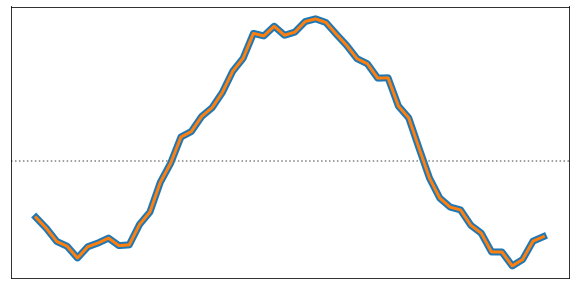

In [30]:
f, a = pl.subplots(1, 1, figsize = (10, 5))

a.axhline(0, ls = ":", c = "grey")
a.plot(C_sum.squeeze(), lw = 7)
a.plot(C[:, 0].squeeze(), lw = 3)
a.set(xticks = [], yticks = [])

pl.show()

***Note:*** For GPUs, in the absence of a custom cuda kernel implementing the convolution-by-addition optimisations, `nn.Conv1d(...)`, `F.conv1d(...)`, or equivalent—i.e., convolution by matrix multiplication—are faster than `nn.Unfold(...)`, etc.

***

# Implementations

* [github.com/angus924/rocket](https://github.com/angus924/rocket)
* [github.com/angus924/minirocket](https://github.com/angus924/minirocket) (demo)



* [github.com/alan-turing-institute/sktime](https://github.com/alan-turing-institute/sktime/) (demo)



* [github.com/timeseriesAI/tsai](https://github.com/timeseriesAI/tsai) [GPU] (Ignacio Oguiza)